In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import io
import glob
from PIL import Image
from datetime import datetime
from skimage.exposure import equalize_hist
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.ndimage import median_filter

In [15]:
# Import files from each position
filenames1 = glob.glob('d1000*120in*.tif')
filenames2 = glob.glob('d1000*60in*.tif')
filenames3 = glob.glob('d1000*cen*.tif')
filenames4 = glob.glob('d1000*60out*.tif')
filenames5 = glob.glob('d1000*120out*.tif')
# Import 2-theta maps
t1 = io.imread('CeO2/maps/*120in*_2thetamap.tif')
t2 = io.imread('CeO2/maps/*60in*_2thetamap.tif')
t3 = io.imread('CeO2/maps/*cen*_2thetamap.tif')
t4 = io.imread('CeO2/maps/*60out*_2thetamap.tif')
t5 = io.imread('CeO2/maps/*120out*_2thetamap.tif')
# Import polarization scaling map
p1 = io.imread('CeO2/maps/*120in*_polscalemap.tif')
p2 = io.imread('CeO2/maps/*60in*_polscalemap.tif')
p3 = io.imread('CeO2/maps/*cen*_polscalemap.tif')
p4 = io.imread('CeO2/maps/*60out*_polscalemap.tif')
p5 = io.imread('CeO2/maps/*120out*_polscalemap.tif')


def read_files(filenames):
    data = []
    for i in range(0, len(filenames)):
        data.append(io.imread(filenames[i]))
    data = np.asarray(data)
    
    return data

# Import data at each position
data1 = read_files(filenames1)
data2 = read_files(filenames2)
data3 = read_files(filenames3)
data4 = read_files(filenames4)
data5 = read_files(filenames5)

# Set all values less -1 to -1
# -2 seems to indicate dead pixels on pilatus?
data1[data1<=-1] = -1
data2[data2<=-1] = -1
data3[data3<=-1] = -1
data4[data4<=-1] = -1
data5[data5<=-1] = -1

# Average all images taken at each position
a1 = np.sum(data1, axis = 0)/data1.shape[0]
a2 = np.sum(data2, axis = 0)/data2.shape[0]
a3 = np.sum(data3, axis = 0)/data3.shape[0]
a4 = np.sum(data4, axis = 0)/data4.shape[0]
a5 = np.sum(data5, axis = 0)/data5.shape[0]

# Clear data arrays
del data1; del data2; del data3; del data4; del data5

# Return a mask with 1 at measured value, NaN at dead pixels or intermodule gaps
def nan_mask(data):
    mask = np.copy(data)
    mask[mask>=0] = 1
    mask[mask<0] = np.nan
    return mask

# Set non-measured pixels to NaN
n1 = np.multiply(a1, nan_mask(a1))
n2 = np.multiply(a2, nan_mask(a2))
n3 = np.multiply(a3, nan_mask(a3))
n4 = np.multiply(a4, nan_mask(a4))
n5 = np.multiply(a5, nan_mask(a5))
# Apply polarization scaling correction
n1 = np.divide(n1, p1)
n2 = np.divide(n2, p2)
n3 = np.divide(n3, p3)
n4 = np.divide(n4, p4)
n5 = np.divide(n5, p5)

In [12]:
def bin_map(tmap, nbins):
    """
    Bin 2-theta map
    Input (2-theta map, total number of bins)
    Return bin, map of bin index
    """
    bins = np.linspace(np.min(tmap), np.max(tmap), num = nbins)
    binned = np.digitize(tmap, bins) -1 # Digitize index starts at 1
    return bins, binned

def unwrap_image(data, datamap, bins = 800):
    """
    Unwraps a 2D diffraction image
    Takes input of diffraction pattern, 2-theta map, and number of bins
        diffraction pattern = data, 2-theta map = datamap, number of bins = bins
    Defaults to 800 bins if no input is provided
    Return bins and unwrapped radial array where rows correspond to each 2-theta bin
    """
    bins, binmap = bin_map(datamap, bins) # Bin input 2-theta map (bins, map of bins)
    values = np.array((binmap.ravel(), data.ravel())) # Values from diffraction pattern (bin, values)
    rind = np.unique(values[0]) # Unique indicies 
    
    avals = [] # Empty array 
    lengths = np.zeros(len(rind)) # Total count of values at each 2-theta
    for i in range (0, len(rind)):
        pos = np.where(values[0] == rind[i])
        vals = np.ndarray.flatten(values[:, pos][1])
        lengths[i] = len(vals)
        avals.append(vals)
   
    radial_array = np.zeros((len(avals), int(np.max(lengths)))) # Output array for unwrapped values
    for i in range (0, len(avals)):
        nan_array = np.empty( int( np.max(lengths) - len(avals[i]) ) ) # Initialize empty array for values not in measurement
        nan_array[:] = np.nan # Set all values in array to NaN
        radial_array[i] = np.concatenate( (avals[i], nan_array) )
    # Return 2-theta bins and unwrapped array
    return bins, radial_array

def bootstrap_resample(rad_array):
    """
    --- UNUSED FUNCTION ---
    Bootstrap resample unwrapped radial array along horizontal
    Returned array has same number of samples along horizontal
    Subsamples are 10 for no particular reason
    """
    out_arr = np.empty(rad_array.shape) # Initialize output array
    for i in range (rad_array.shape[0]): # Loop over horizontal rows
        data = np.copy(rad_array[i]) # Copy current row
        data = data[~np.isnan(data)] # Remove nans
        resamples = np.random.choice(data, size = (10, rad_array.shape[1]), replace = True) # 10 x [input horizontal] random samples with replacement 
        medians = np.nanmedian(resamples, axis = 0) # Take median across axis 0 to return [input horizontal] medians
        out_arr[i] = medians # Put medians in output array
    return out_arr


def interpolate_bstrap(bmap, bins, min_val, max_val):
    """
    --- UNUSED FUNCTION ---
    Interpolate the bootstrapped data map and return interpolating function
    Pick range of 2-theta values at high 2-theta to use for extrapolation at high 2-theta
    Pass bootstrapped map, bins from unwrapping function ( unwrap_image() ), min 2theta, and max 2theta
    Extrapolate to twice the input 2-theta value
    """
    median_vals = np.nanmedian(bmap, axis = 1) # Take median of bootstrapped array
    f = interp1d(bins, median_vals, kind = 'slinear', fill_value = 'extrapolate') # Interpolate data using order 1 splines
    x_extrap = np.linspace(min_val, max_val, 100) # Get x-values for extrapolation at high 2-theta
    y_extrap = f(x_extrap) # Get y-values for extrapolation from previous interpolation
    #f_extrap = interp1d(x_extrap, y_extrap, kind = 'slinear', fill_value = 'extrapolate') # Function for extrapolating high 2-theta using order 1 splines
    # Add median filter to extrapolation section
    f_extrap = interp1d(x_extrap, medfilt(y_extrap, 5), kind = 'slinear', fill_value = 'extrapolate') # Function for extrapolating high 2-theta using order 1 splines
    
    # Calculate new values including extrapolated region
    # Use 5000 points for interpolation for no particular reason
    x_new = np.linspace(bins[0], bins[-1]*2, 5000) # X values
    y_new = [] # Array for y values
    for i in range (0, len(x_new)):
        if x_new[i] <= min_val:
            y_new.append(f(x_new[i])) # Below cutoff use intepolation of data
        if x_new[i] > min_val:
            y_new.append(f_extrap(x_new[i])) # Above cutoff use extrapolation from cutoff range specified
    y_new = np.array(y_new)
    # Calculate interpolating function for new y-values that include extrapolation at high 2-theta
    # Use order 1 splines for interpolation
    f_out = interp1d(x_new,y_new, kind = 'slinear', fill_value = 'extrapolate')
    return f_out

def interpolate_uwrap(umap, bins, min_val, max_val):
    """
    Interpolate the unwrapped data map and return interpolating function
    Pick range of 2-theta values at high 2-theta to use for extrapolation at high 2-theta
    Pass bootstrapped map, bins from unwrapping function ( unwrap_image() ), min 2theta, and max 2theta
    Extrapolate to twice the input 2-theta value
    """
    median_vals = np.nanmedian(umap, axis = 1) # Take median of bootstrapped array
    f = interp1d(bins, median_vals, kind = 'slinear', fill_value = 'extrapolate') # Interpolate data using order 1 splines
    x_extrap = np.linspace(min_val, max_val, 100) # Get x-values for extrapolation at high 2-theta
    y_extrap = f(x_extrap) # Get y-values for extrapolation from previous interpolation
    f_extrap = interp1d(x_extrap, y_extrap, kind = 'slinear', fill_value = 'extrapolate') # Function for extrapolating high 2-theta using order 1 splines
    # Add median filter to extrapolation section
    f_extrap = interp1d(x_extrap, medfilt(y_extrap, 5), kind = 'slinear', fill_value = 'extrapolate') # Function for extrapolating high 2-theta using order 1 splines
    
    # Calculate new values including extrapolated region
    # Use 5000 points for interpolation for no particular reason
    x_new = np.linspace(bins[0], bins[-1]*2, 5000) # X values
    y_new = [] # Array for y values
    for i in range (0, len(x_new)):
        if x_new[i] <= min_val:
            y_new.append(f(x_new[i])) # Below cutoff use intepolation of data
        if x_new[i] > min_val:
            y_new.append(f_extrap(x_new[i])) # Above cutoff use extrapolation from cutoff range specified
    y_new = np.array(y_new)
    # Calculate interpolating function for new y-values that include extrapolation at high 2-theta
    # Use order 1 splines for interpolation
    f_out = interp1d(x_new,y_new, kind = 'slinear', fill_value = 'extrapolate')
    return f_out


def gain_map_all_pos(pos1, pos2, pos3, pos4, pos5, tmap1, tmap2, tmap3, tmap4, tmap5, e_min, e_max, bins = 800):
    """
    Calculate a gain map from five positions, return calculated map at each position
    Input set of average images at three positions (pos1, pos2, pos3) and corresponding 2-theta maps (tmap1, tmap2, tmap3)
    Provide min/max for 2-theta region to use for extrapolation for high 2-theta (e_min, e_max). This provides an estimated gain at high 2-theta
    Specify number of bins to use for radial average, defaults to 800
    Gain map at edges where information is estimated by extrapolation is probably not super reliable
    Gain map inside beamstop is also not correct
    """
    # Unwrap images to generate maps of 2-theta vs number of counts
    bins1, map1 = unwrap_image(pos1, tmap1, bins)
    bins2, map2 = unwrap_image(pos2, tmap2, bins)
    bins3, map3 = unwrap_image(pos3, tmap3, bins)
    bins4, map4 = unwrap_image(pos4, tmap4, bins)
    bins5, map5 = unwrap_image(pos5, tmap5, bins)
    # Get interpolated 1D function corresponding to 1D average of input diffraction patterns
    ifun1 = interpolate_uwrap(map1, bins1, e_min, e_max)
    ifun2 = interpolate_uwrap(map2, bins2, e_min, e_max)
    ifun3 = interpolate_uwrap(map3, bins3, e_min, e_max)
    ifun4 = interpolate_uwrap(map4, bins4, e_min, e_max)
    ifun5 = interpolate_uwrap(map5, bins5, e_min, e_max)
    
    signal = (ifun1(tmap1)+ifun2(tmap1)+ifun3(tmap1)+ifun4(tmap1)+ifun5(tmap1))/5 # Generate 5 estimated signals at position and then average
    gmap1 = pos1/signal
    signal = (ifun1(tmap2)+ifun2(tmap2)+ifun3(tmap2)+ifun4(tmap2)+ifun5(tmap2))/5 # Generate 5 estimated signals at position and then average
    gmap2 = pos2/signal
    signal = (ifun1(tmap3)+ifun2(tmap3)+ifun3(tmap3)+ifun4(tmap3)+ifun5(tmap3))/5 # Generate 5 estimated signals at position and then average
    gmap3 = pos3/signal
    signal = (ifun1(tmap4)+ifun2(tmap4)+ifun3(tmap4)+ifun4(tmap4)+ifun5(tmap4))/5 # Generate 5 estimated signals at position and then average
    gmap4 = pos4/signal
    signal = (ifun1(tmap5)+ifun2(tmap5)+ifun3(tmap5)+ifun4(tmap5)+ifun5(tmap5))/5 # Generate 5 estimated signals at position and then average
    gmap5 = pos5/signal
    
    return gmap1, gmap2, gmap3, gmap4, gmap5 # Return gainmap

# Get gain mask of undamaged and damaged pixels (umap, dmap)
# Define damaged pixels as those with responses more than 4 sigma away from the mean
# Define sigma using 1.4826*MAD
def damaged_pixels(data):
    median = np.nanmedian(data) # Calculate median
    mad = np.nanmedian(np.abs(data-median)) # Calculate MAD
    sigma = 1.4826*mad # Calculate sigma
    dmap = np.copy(data) # Damaged pixels
    dmap[dmap<(median+4*sigma)] = 0
    umap = np.copy(data) # Undamaged pixels
    umap[umap>(median+4*sigma)] = 0
    return umap, dmap
# Corrects gain map containing damaged pixels
# needs median_filter from scipy.ndimage
def map_correction(gainmap, window_size):
    udmap, damap = damaged_pixels(gainmap) # Get map of undamaged and damaged pixels
    filtered = median_filter(gainmap, window_size) # Apply 3x3 median filter to undamaged pixel map
    return filtered+damap # Add back in gains for damaged pixels

Text(0, 0.5, 'Counts')

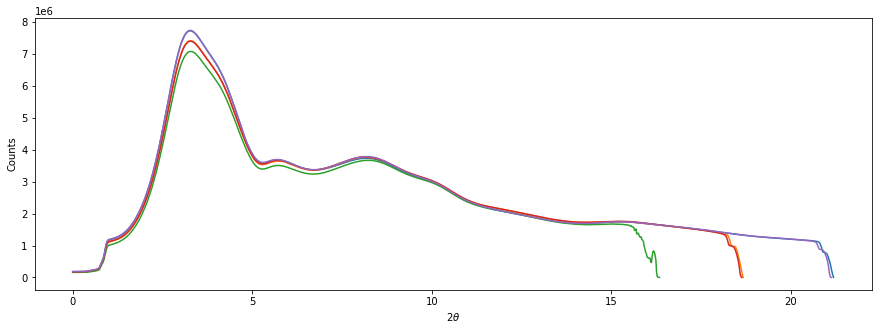

In [35]:
tx1, ty1 = unwrap_image(n1, t1, bins = 800)
tx2, ty2 = unwrap_image(n2, t2, bins = 800)
tx3, ty3 = unwrap_image(n3, t3, bins = 800)
tx4, ty4 = unwrap_image(n4, t4, bins = 800)
tx5, ty5 = unwrap_image(n5, t5, bins = 800)
y1 = np.nanmedian(ty1, axis = 1)
y2 = np.nanmedian(ty2, axis = 1)
y3 = np.nanmedian(ty3, axis = 1)
y4 = np.nanmedian(ty4, axis = 1)
y5 = np.nanmedian(ty5, axis = 1)

plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(tx1, y1)
plt.plot(tx2, y2)
plt.plot(tx3, y3)
plt.plot(tx4, y4)
plt.plot(tx5, y5)
plt.xlabel('2$\\theta$')
plt.ylabel('Counts')

# Use 2-theta from 14 to 15 for extrapolation

Text(0.5, 1.0, 'Diffraction patterns normalized by max intensity')

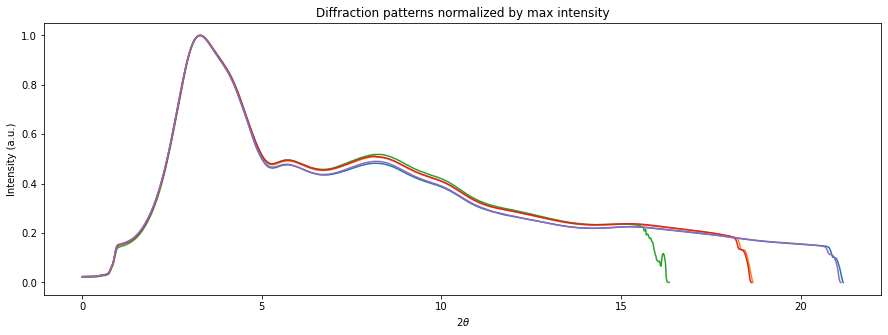

In [37]:
def norm(data):
    return data/np.max(data)

plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(tx1, norm(y1))
plt.plot(tx2, norm(y2))
plt.plot(tx3, norm(y3))
plt.plot(tx4, norm(y4))
plt.plot(tx5, norm(y5))
plt.xlabel('2$\\theta$')
plt.ylabel('Intensity (a.u.)')
plt.title('Diffraction patterns normalized by max intensity')

In [18]:
start, stop = 14, 15
bins = 1000
maps = gain_map_all_pos(n1, n2, n3, n4, n5, t1, t2, t3, t4, t5, start, stop, bins)

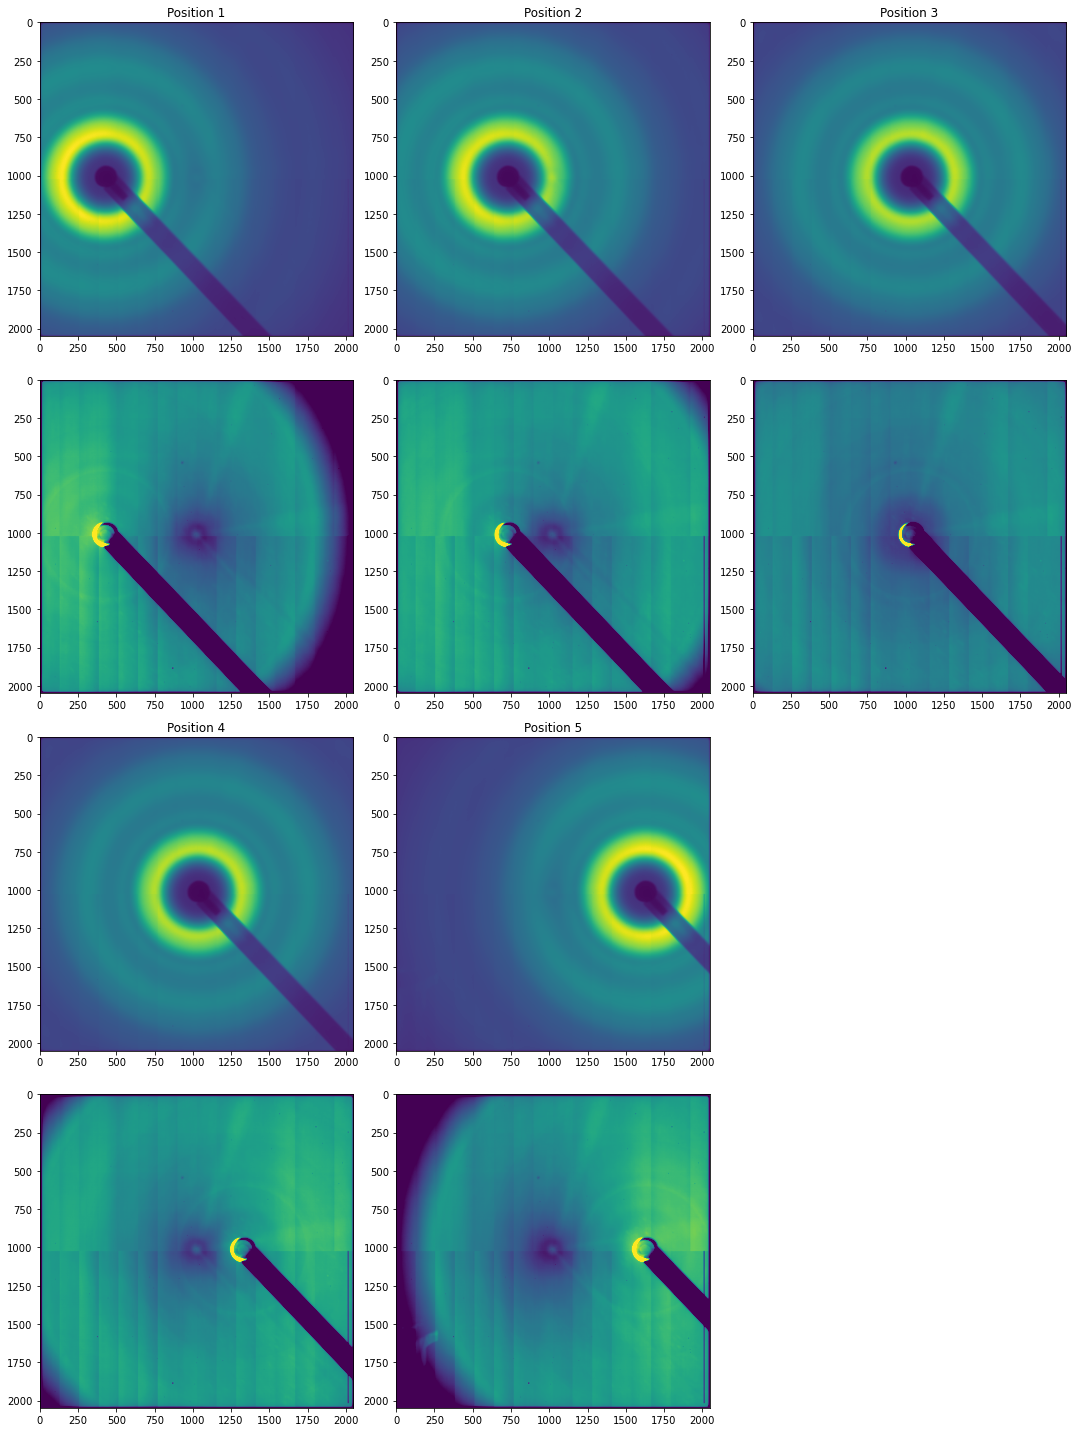

In [20]:
r = 8 * 10**6 # Max intensity shown for diffraction pattern
plt.rcParams["figure.figsize"] = (15, 20)
plt.subplot(4, 3, 1)
plt.imshow(np.nan_to_num(n1), vmax = r)
plt.title('Position 1')
plt.subplot(4, 3, 2)
plt.imshow(np.nan_to_num(n2), vmax = r)
plt.title('Position 2')
plt.subplot(4, 3, 3)
plt.imshow(np.nan_to_num(n3), vmax = r)
plt.title('Position 3')
plt.subplot(4, 3, 7)
plt.imshow(np.nan_to_num(n3), vmax = r)
plt.title('Position 4')
plt.subplot(4, 3, 8)
plt.imshow(np.nan_to_num(n5), vmax = r)
plt.title('Position 5')

plt.subplot(4, 3, 4)
plt.imshow(np.nan_to_num(maps[0]), vmin = 0.85, vmax = 1.15)
plt.subplot(4, 3, 5)
plt.imshow(np.nan_to_num(maps[1]), vmin = 0.85, vmax = 1.15)
plt.subplot(4, 3, 6)
plt.imshow(np.nan_to_num(maps[2]), vmin = 0.85, vmax = 1.15)
plt.subplot(4, 3, 10)
plt.imshow(np.nan_to_num(maps[3]), vmin = 0.85, vmax = 1.15)
plt.subplot(4, 3, 11)
plt.imshow(np.nan_to_num(maps[4]), vmin = 0.85, vmax = 1.15)

plt.tight_layout()

Text(0.5, 1.0, 'Median gain map')

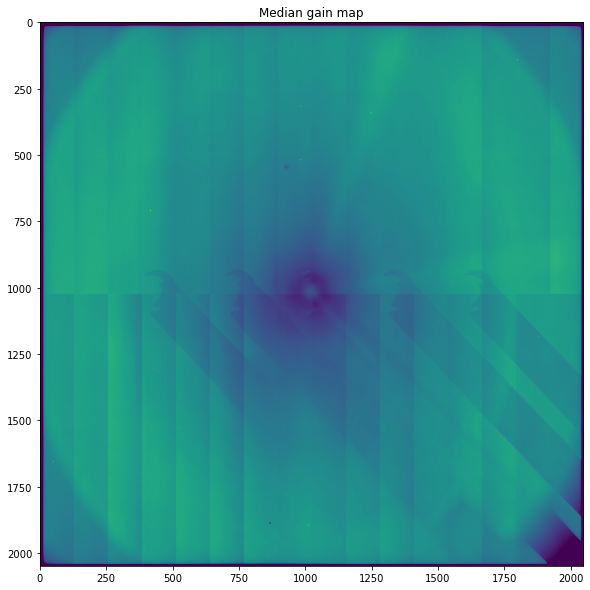

In [29]:
window_size = 7 # Median filter window size

plt.rcParams["figure.figsize"] = (10, 10)
median_map = np.nan_to_num(np.median(maps, axis = 0))
#plt.imshow(median_map, vmin = 0.85, vmax = 1.15)
# Apply correction to map
corrmap = map_correction(median_map, window_size)
plt.imshow(corrmap, vmin = 0.85, vmax = 1.15)
plt.title('Median gain map')

In [38]:
# Calculate radial averages after applying gain correction
tx1, ty1 = unwrap_image(n1/corrmap, t1, bins = 800)
tx2, ty2 = unwrap_image(n2/corrmap, t2, bins = 800)
tx3, ty3 = unwrap_image(n3/corrmap, t3, bins = 800)
tx4, ty4 = unwrap_image(n4/corrmap, t4, bins = 800)
tx5, ty5 = unwrap_image(n5/corrmap, t5, bins = 800)
y1 = np.nanmedian(ty1, axis = 1)
y2 = np.nanmedian(ty2, axis = 1)
y3 = np.nanmedian(ty3, axis = 1)
y4 = np.nanmedian(ty4, axis = 1)
y5 = np.nanmedian(ty5, axis = 1)

Text(0.5, 1.0, 'Gain corrected, normalized by max intensity')

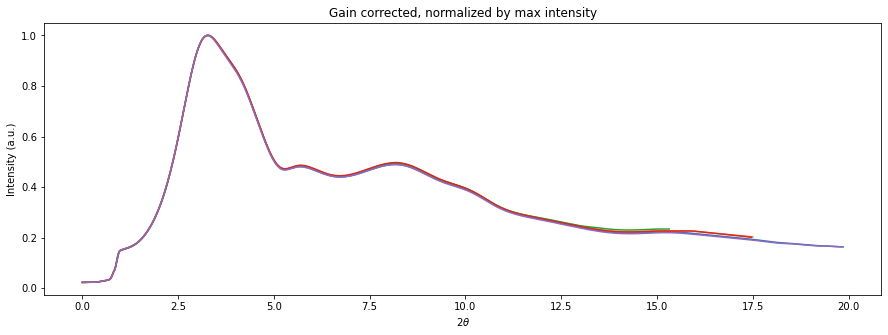

In [39]:
plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(tx1[0:750], norm(y1[0:750]))
plt.plot(tx2[0:750], norm(y2[0:750]))
plt.plot(tx3[0:750], norm(y3[0:750]))
plt.plot(tx4[0:750], norm(y4[0:750]))
plt.plot(tx5[0:750], norm(y5[0:750]))
plt.xlabel('2$\\theta$')
plt.ylabel('Intensity (a.u.)')
plt.title('Gain corrected, normalized by max intensity')

Text(0.5, 1.0, 'Position specific gain map, position 3')

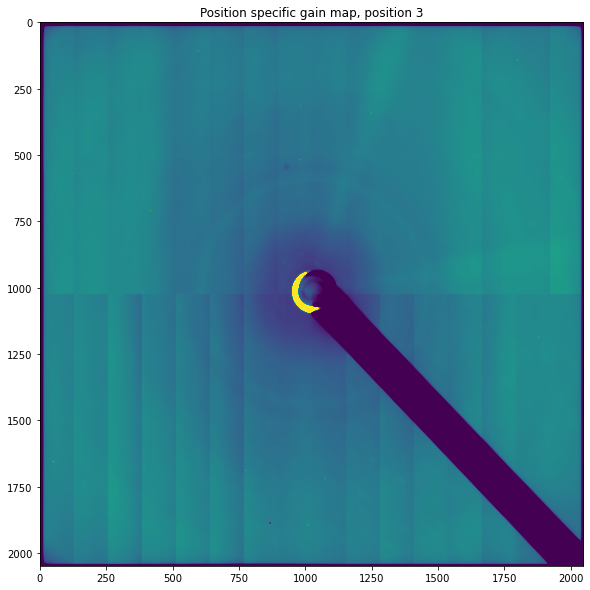

In [46]:
## Don't use this position specific gain map, it seems to create new problems
window_size = 7 # Median filter window size
n = 2 # Select position to apply filter to (indexing starts at 0, so Pos 1 in previous figure corresponds to 0, Pos 2 -> 1, etc)
plt.rcParams["figure.figsize"] = (10, 10)
fmap = np.nan_to_num(maps[2])
#plt.imshow(median_map, vmin = 0.85, vmax = 1.15)
# Apply correction to map
corrmap_p = map_correction(fmap, window_size)
plt.imshow(corrmap_p, vmin = 0.85, vmax = 1.15)
plt.title('Position specific gain map, position 3')

Text(0.5, 1.0, 'Gain corrected, normalized by max intensity')

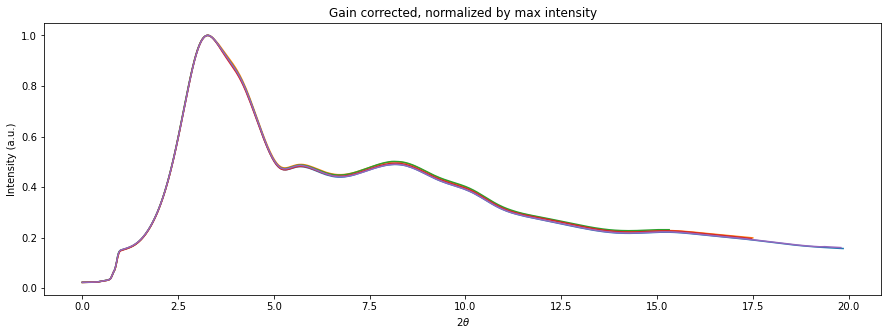

In [47]:
# Calculate radial averages after applying gain correction
tx1, ty1 = unwrap_image(n1/corrmap_p, t1, bins = 800)
tx2, ty2 = unwrap_image(n2/corrmap_p, t2, bins = 800)
tx3, ty3 = unwrap_image(n3/corrmap_p, t3, bins = 800)
tx4, ty4 = unwrap_image(n4/corrmap_p, t4, bins = 800)
tx5, ty5 = unwrap_image(n5/corrmap_p, t5, bins = 800)
y1 = np.nanmedian(ty1, axis = 1)
y2 = np.nanmedian(ty2, axis = 1)
y3 = np.nanmedian(ty3, axis = 1)
y4 = np.nanmedian(ty4, axis = 1)
y5 = np.nanmedian(ty5, axis = 1)
plt.rcParams["figure.figsize"] = (15, 5)
plt.plot(tx1[0:750], norm(y1[0:750]))
plt.plot(tx2[0:750], norm(y2[0:750]))
plt.plot(tx3[0:750], norm(y3[0:750]))
plt.plot(tx4[0:750], norm(y4[0:750]))
plt.plot(tx5[0:750], norm(y5[0:750]))
plt.xlabel('2$\\theta$')
plt.ylabel('Intensity (a.u.)')
plt.title('Gain corrected, normalized by max intensity')

In [45]:
# Export calculated gain map
gainmapfilename = '11-ID-B_div'
# Define gain map format
g_form = 1 # Set to 1 if the gain map is to be multiplied by measured images, 0 if it is to be divided

# Change to whatever format and then remove any nans which may be present
if g_form == 1:
    nmap = np.nan_to_num(corrmap)
if g_form == 0:
    nmap = np.nan_to_num(1/corrmap)
else:
    nmap = np.nan_to_num(corrmap) # Format parameter to something other than 0 returns a multiplied map
# Remove any inf/very large values created by any divide by zeros
nmap[nmap>10**10] = 0
nmap[nmap<-10**10] = 0

# Export map as 32 bit tif
im = Image.fromarray(np.float32(nmap), mode='F') # float32
im.save(gainmapfilename+'_'+datetime.today().strftime('%Y-%m-%d')+'.tif', 'TIFF')
